In [1]:
import findspark
findspark.init()

import sys
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType
from pyspark.sql.window import Window
import pyspark.sql.functions as F
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import lit
from pyspark.sql.functions import when
import matplotlib.pyplot as plt
import pandas as pd
import decimal
import numpy as np
import matplotlib.ticker as ticker

spark = SparkSession.builder.appName('Energy_Data').getOrCreate()

In [2]:
Energy_df = spark.read.csv("Energy_data.csv", header=True,inferSchema=True)

In [3]:
display(Energy_df)
Energy_df.count()
Energy_df.show(1)

DataFrame[YEAR: int, SOURCE: string, Data Source ID: string, ORG_UNIT: int, ORG_NAME: string, ORG_TYPE: string, ORG_PART: int, ENERGY_TYPE: string, ENERGY_UNIT: string, SUB_SECTOR: string, CATEGORY: string, SUB_CATEGORY: string, CONSUMPTION_TOTAL: string, CONNECTION_TOTAL: double, EMISSIONS_TCO2e: string, EMISSIONS_TCO2eWithimports: string]

+----+--------+--------------+--------+------------+--------+--------+-----------+-----------+----------+---------+---------------+-----------------+----------------+---------------+--------------------------+
|YEAR|  SOURCE|Data Source ID|ORG_UNIT|    ORG_NAME|ORG_TYPE|ORG_PART|ENERGY_TYPE|ENERGY_UNIT|SUB_SECTOR| CATEGORY|   SUB_CATEGORY|CONSUMPTION_TOTAL|CONNECTION_TOTAL|EMISSIONS_TCO2e|EMISSIONS_TCO2eWithimports|
+----+--------+--------------+--------+------------+--------+--------+-----------+-----------+----------+---------+---------------+-----------------+----------------+---------------+--------------------------+
|2020|BC Hydro|          9080| 5923008|Port Alberni|    City| 1005923|       ELEC|        kWh|       Res|Res-Total|Res-Total-Total|      96371327.18|          8739.0|    1027.960823|               3755.269382|
+----+--------+--------------+--------+------------+--------+--------+-----------+-----------+----------+---------+---------------+-----------------+-----------

In [4]:
Energy_df.createOrReplaceTempView("energy_data")

### Transforming and Filtering the data based on data quality checks

In [5]:
energy_data = spark.sql(""" Select YEAR, Source, ORG_UNIT, ORG_NAME, ORG_TYPE, ENERGY_TYPE,ENERGY_UNIT,
                         SUB_SECTOR, CATEGORY,SUB_CATEGORY,CONSUMPTION_TOTAL,
                         CONNECTION_TOTAL,EMISSIONS_TCO2e,EMISSIONS_TCO2eWithimports
                         from energy_data 
                         where ORG_NAME IN ('Burnaby','Coquitlam','Delta','Langley',
                         'Metro-Vancouver','New Westminster','Richmond','Surrey','Vancouver','White Rock')  
                         """)
 
energy_data.createOrReplaceTempView("Energy_dataset")

In [6]:
cleaned_dataset = spark.sql("""
  SELECT 
     YEAR, Source, ORG_UNIT, ORG_NAME, ORG_TYPE, ENERGY_TYPE,
     CASE 
         WHEN ENERGY_UNIT = 'GJ' THEN 'kWh'
         ELSE ENERGY_UNIT
     END AS Energy_Unit,
     SUB_SECTOR,
     CASE 
         WHEN ENERGY_UNIT = 'GJ' THEN CAST(REPLACE(CONSUMPTION_TOTAL, ',', '') AS BIGINT) * 277.778
         WHEN CONCAT('', CONSUMPTION_TOTAL) LIKE '%W%' THEN CAST(REPLACE(CONSUMPTION_TOTAL, 'W', '0') AS BIGINT)
         ELSE CAST(REPLACE(COALESCE(CONSUMPTION_TOTAL, '0'), ',', '') AS BIGINT)
     END AS Consumption_Total,
     CAST(REPLACE(CONNECTION_TOTAL, ',', '') AS BIGINT) AS CONNECTION_TOTAL,
     CASE
         WHEN CONCAT('', EMISSIONS_TCO2e) LIKE '%W%' THEN CAST(REPLACE(EMISSIONS_TCO2e, 'W', '0') AS BIGINT)
         ELSE CAST(REPLACE(COALESCE(EMISSIONS_TCO2e, '0'), ',', '') AS BIGINT)
     END AS EMISSIONS_TCO2e,
     CAST(REPLACE(EMISSIONS_TCO2eWithimports, ',', '') AS BIGINT) AS EMISSIONS_TCO2eWithimports
     FROM Energy_dataset""")
 
cleaned_dataset.createOrReplaceTempView("cleaned_energy_dataset")

### Cleaning data and removing invalid records

In [7]:
#we are only retraining the records for current 4 years and based on data availability is till 2020.
period_set = spark.sql("""Select * from cleaned_energy_dataset where YEAR IN (2017,2018,2019,2020)
                        and ENERGY_TYPE NOT IN ('WOOD','OIL','DPRO')  
                        """)
 
period_set.createOrReplaceTempView("Energy_period_dataset")

In [8]:
energy_df = spark.sql(""" Select distinct YEAR, Source, ORG_NAME, ORG_Type, ENERGY_TYPE,ENERGY_UNIT,
                            SUB_SECTOR
                            from Energy_period_dataset
                            where ORG_NAME IN ('Burnaby','Coquitlam','Delta','Langley',
                            'Metro-Vancouver','New Westminster','Richmond','Surrey','Vancouver','White Rock')  
                            """)
energy_df.createOrReplaceTempView("Energy_df")

## Data Analytics

### Metric 1 - CO2 emissions by Org Types 

In [9]:
CO2_emissions = spark.sql("""Select YEAR,ORG_TYPE,sum(EMISSIONS_TCO2e) as Total_CO2_Emission 
                              from Energy_period_dataset    
                              group by YEAR, ORG_TYPE 
                              order by Year Desc,Org_Type
                               """)
CO2_emissions.createOrReplaceTempView("CO2_emissions")
CO2_emissions.show()

+----+--------------------+------------------+
|YEAR|            ORG_TYPE|Total_CO2_Emission|
+----+--------------------+------------------+
|2020|                City|           3908709|
|2020|District Municipa...|            684141|
|2020|   Regional District|           5816434|
|2019|                City|           3972010|
|2019|District Municipa...|            670848|
|2019|   Regional District|           5849048|
|2018|                City|           3858592|
|2018|District Municipa...|            648385|
|2018|   Regional District|           5681240|
|2017|                City|           4059945|
|2017|District Municipa...|            606731|
|2017|   Regional District|           5924356|
+----+--------------------+------------------+



### Metric 2 - Total Energy Consumption by for Res and CSMI Subsectors

In [10]:
Total_CONSUMPTION = spark.sql(""" Select Year,SUB_SECTOR,
                               sum(CONSUMPTION_TOTAL) as Total_Energy_Consumption
                        from Energy_period_dataset
                        group by Year,SUB_SECTOR
                        """)
Total_CONSUMPTION.show()
Total_CONSUMPTION.createOrReplaceTempView("Total_consumption_by_sector")

+----+----------+------------------------+
|Year|SUB_SECTOR|Total_Energy_Consumption|
+----+----------+------------------------+
|2018|       Res|         35983717851.984|
|2019|      CSMI|         53365044874.158|
|2017|      CSMI|         53089217716.560|
|2018|      CSMI|         52275275293.248|
|2020|       Res|         37863255114.576|
|2017|       Res|         38063603380.212|
|2020|      CSMI|         51678674280.852|
|2019|       Res|         36723166319.614|
+----+----------+------------------------+



###  Metric 3 - Total CO2 emission for Vancouver and adj. places

In [11]:
energy_source_sector = spark.sql(""" Select ORG_Name,            
                       sum(EMISSIONS_TCO2e) as Total_CO2_Emission
                        from Energy_period_dataset
                        group by Org_Name
                        order by Total_CO2_Emission desc
                        """)
energy_source_sector.show()
energy_source_sector.createOrReplaceTempView("energy_source_sector")

+---------------+------------------+
|       ORG_Name|Total_CO2_Emission|
+---------------+------------------+
|Metro-Vancouver|          23271078|
|      Vancouver|           5768776|
|         Surrey|           3624363|
|          Delta|           2556549|
|        Burnaby|           2313833|
|       Richmond|           2284410|
|      Coquitlam|           1055220|
|New Westminster|            584121|
|     White Rock|            157874|
|        Langley|             64215|
+---------------+------------------+



###  Metric 4 - Total CO2 emission for Res and CSMI Subsectors

In [12]:
Total_Emission = spark.sql(""" Select Year,SUB_SECTOR,
                               sum(EMISSIONS_TCO2e) as Total_CO2_Emission
                        from Energy_period_dataset
                        group by Year,SUB_SECTOR
                        """)
Total_Emission.show()
Total_Emission.createOrReplaceTempView("Total_emission_by_sector")

+----+----------+------------------+
|Year|SUB_SECTOR|Total_CO2_Emission|
+----+----------+------------------+
|2018|       Res|           4128517|
|2019|      CSMI|           6246139|
|2017|      CSMI|           6158493|
|2018|      CSMI|           6059700|
|2020|       Res|           4317870|
|2017|       Res|           4432539|
|2020|      CSMI|           6091414|
|2019|       Res|           4245767|
+----+----------+------------------+



### Metric 5 - Total energy Consumption & CO2 Emission by Source

In [13]:
Total_energy_source = spark.sql(""" Select Source,
                               sum(CONSUMPTION_TOTAL) as Energy_Consumption,
                       sum(EMISSIONS_TCO2e) as CO2_Emission
                        from Energy_period_dataset
                        group by Source
                        order by CO2_Emission,Energy_Consumption
                        """)
Total_energy_source.show()
Total_energy_source.createOrReplaceTempView("energy_sources")

+--------------------+------------------+------------+
|              Source|Energy_Consumption|CO2_Emission|
+--------------------+------------------+------------+
|New Westminster E...|    3479019642.000|       37102|
|            BC Hydro|  131430556439.000|     1401886|
|          Fortis Gas|  224132378750.204|    40241451|
+--------------------+------------------+------------+



### Metric 6 - CO2 emission of the areas by source that produce max Carbon

In [14]:
Fortis_gas_areas = spark.sql(""" Select ORG_NAME,SUB_SECTOR,
                              
                               sum(EMISSIONS_TCO2e) as CO2_Emission
                        from Energy_period_dataset
                        where Source = 'Fortis Gas' and Year=
                        '2020'
                        group by ORG_NAME,SUB_SECTOR
                       order by CO2_Emission,Sub_sector
                        """)
Fortis_gas_areas.show()
Fortis_gas_areas.createOrReplaceTempView("Fortis_gas_areas")

+---------------+----------+------------+
|       ORG_NAME|SUB_SECTOR|CO2_Emission|
+---------------+----------+------------+
|     White Rock|       Res|       19112|
|     White Rock|      CSMI|       19474|
|New Westminster|       Res|       38918|
|New Westminster|      CSMI|      105322|
|      Coquitlam|      CSMI|      114855|
|          Delta|       Res|      136939|
|      Coquitlam|       Res|      139533|
|       Richmond|       Res|      191023|
|        Burnaby|       Res|      194644|
|         Surrey|      CSMI|      333432|
|       Richmond|      CSMI|      345489|
|        Burnaby|      CSMI|      351137|
|      Vancouver|       Res|      487976|
|          Delta|      CSMI|      522086|
|         Surrey|       Res|      556723|
|      Vancouver|      CSMI|      871945|
|Metro-Vancouver|       Res|     2396352|
|Metro-Vancouver|      CSMI|     3226372|
+---------------+----------+------------+



## Data Visualization

### Graph 1 - Showing the CO2 emission in different ORG TYPEs

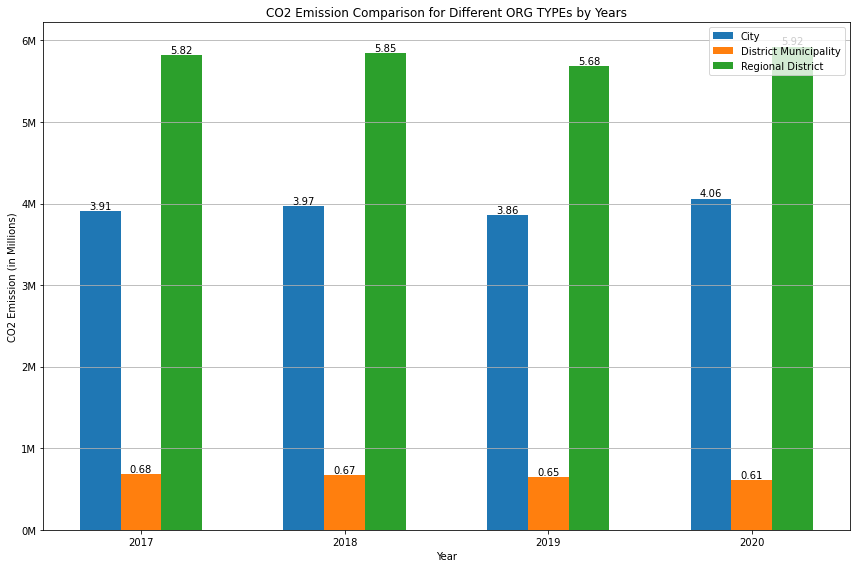

In [15]:
co2_emissions_pd = CO2_emissions.toPandas()
required_org_types = ['City', 'District Municipality', 'Regional District']
co2_emissions_pd_filtered = co2_emissions_pd[co2_emissions_pd['ORG_TYPE'].isin(required_org_types)]
years = sorted(co2_emissions_pd_filtered['YEAR'].unique())
num_years = len(years)
org_types = co2_emissions_pd_filtered['ORG_TYPE'].unique()
num_org_types = len(org_types)
bar_width = 0.2
plt.figure(figsize=(12, 8))
for i, org_type in enumerate(org_types):
    org_data = co2_emissions_pd_filtered[co2_emissions_pd_filtered['ORG_TYPE'] == org_type]

    index = np.arange(num_years) + i * bar_width - (num_org_types - 1) * bar_width / 2 
    bars = plt.bar(index, org_data['Total_CO2_Emission'] / 1e6, bar_width, label=org_type)
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')
plt.xlabel('Year')
plt.ylabel('CO2 Emission (in Millions)')
plt.title('CO2 Emission Comparison for Different ORG TYPEs by Years')

plt.xticks(np.arange(num_years), years)
plt.legend()
plt.grid(axis='y')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}M'))

plt.tight_layout()
plt.show()

### Graph 2 - Showing the total Energy Consumption for Res and CSMI Subsectors

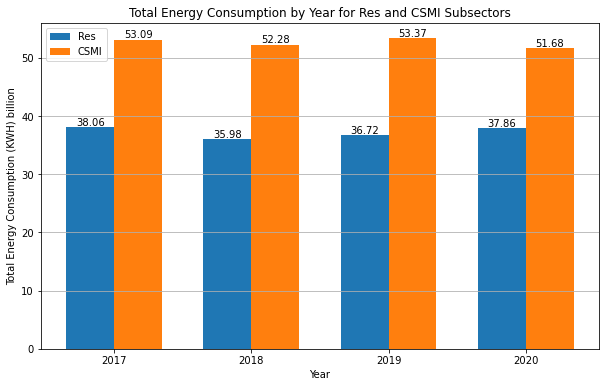

In [16]:
total_consumption_pandas = Total_CONSUMPTION.toPandas()
res_data = total_consumption_pandas[total_consumption_pandas['SUB_SECTOR'] == 'Res']
csmi_data = total_consumption_pandas[total_consumption_pandas['SUB_SECTOR'] == 'CSMI']
bar_width = 0.35
res_positions = res_data['Year']
csmi_positions = csmi_data['Year'] + bar_width
plt.figure(figsize=(10, 6))
# Plotting the bars for 'Res' and 'CSMI'
plt.bar(res_positions, res_data['Total_Energy_Consumption'], width=bar_width, label='Res')
plt.bar(csmi_positions, csmi_data['Total_Energy_Consumption'], width=bar_width, label='CSMI')
# Adding labels and units to the axes
plt.xlabel('Year')
plt.ylabel('Total Energy Consumption (KWH) billion') 
plt.title('Total Energy Consumption by Year for Res and CSMI Subsectors')
plt.legend()
plt.grid(axis='y')
for i, val in enumerate(res_data['Total_Energy_Consumption']):
    val = float(val)  
    val_in_billion = val / 1e9  
    plt.text(res_positions.iloc[i], val + 0.1, f'{val_in_billion:.2f}', ha='center', va='bottom')

for i, val in enumerate(csmi_data['Total_Energy_Consumption']):
    val = float(val)  
    val_in_billion = val / 1e9  
    plt.text(csmi_positions.iloc[i], val + 0.1, f'{val_in_billion:.2f}', ha='center', va='bottom')

plt.xticks(res_data['Year'] + bar_width / 2, res_data['Year'])
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x / 1e9:.0f}'))
plt.show()

### Graph 3 - Total CO2 Emission Distribution by areas

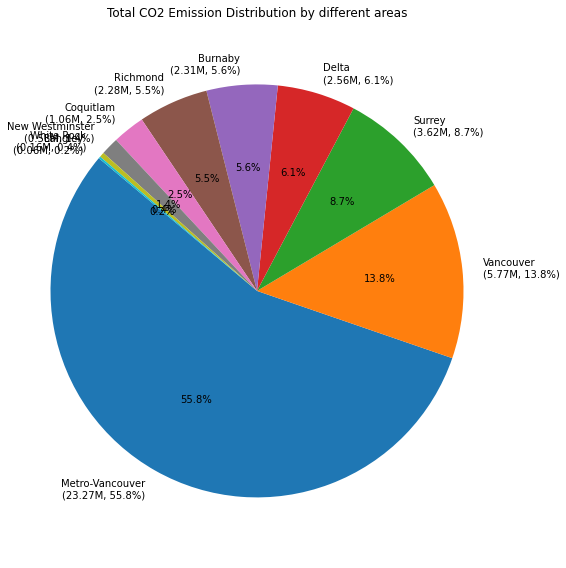

In [17]:
energy_source_pd = energy_source_sector.toPandas()
plt.figure(figsize=(8, 8))
total_emissions = energy_source_pd['Total_CO2_Emission'].sum()
percentages = 100 * energy_source_pd['Total_CO2_Emission'] / total_emissions
labels = [f'{name}\n({value / 1_000_000:.2f}M, {percentage:.1f}%)' for name, value, percentage in zip(energy_source_pd['ORG_Name'], energy_source_pd['Total_CO2_Emission'], percentages)]

plt.pie(energy_source_pd['Total_CO2_Emission'], labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Total CO2 Emission Distribution by different areas')
plt.axis('equal')
plt.tight_layout()
plt.show()

### Graph 4 - Showing the CO2 emissions for Res and CSMI Subsectors

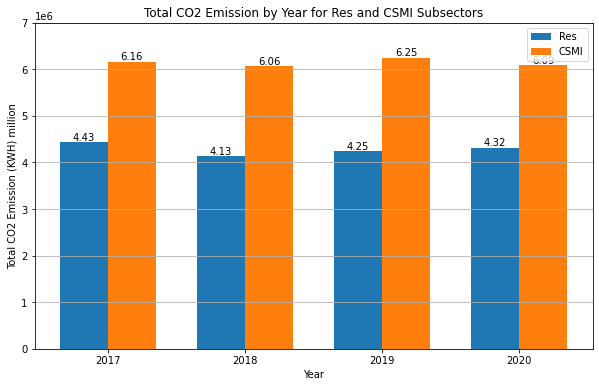

In [18]:
total_emission_pandas = Total_Emission.toPandas()
res_data_em = total_emission_pandas[total_emission_pandas['SUB_SECTOR'] == 'Res']
csmi_data_em = total_emission_pandas[total_emission_pandas['SUB_SECTOR'] == 'CSMI']
bar_width = 0.35
res_positions_em = res_data_em['Year']
csmi_positions_em = csmi_data_em['Year'] + bar_width
plt.figure(figsize=(10, 6))
plt.bar(res_positions_em, res_data_em['Total_CO2_Emission'], width=bar_width, label='Res')
plt.bar(csmi_positions_em, csmi_data_em['Total_CO2_Emission'], width=bar_width, label='CSMI')
plt.xlabel('Year')
plt.ylabel('Total CO2 Emission (KWH) million')  
plt.title('Total CO2 Emission by Year for Res and CSMI Subsectors')
plt.legend()
plt.grid(axis='y')

for i, val in enumerate(res_data_em['Total_CO2_Emission']):
    val = float(val) 
    val_in_million = val / 1e6  
    plt.text(res_positions_em.iloc[i], val + 0.1, f'{val_in_million:.2f}', ha='center', va='bottom')

for i, val in enumerate(csmi_data_em['Total_CO2_Emission']):
    val = float(val)  
    val_in_million = val / 1e6 
    plt.text(csmi_positions_em.iloc[i], val + 0.1, f'{val_in_million:.2f}', ha='center', va='bottom')

plt.xticks(res_data_em['Year'] + bar_width / 2, res_data_em['Year'])
min_y = 0  
max_y = 7 * 1e6
plt.ylim(min_y, max_y) 
plt.show()

### Graph 5 :  Energy Consumption and CO2 Emission by Source 

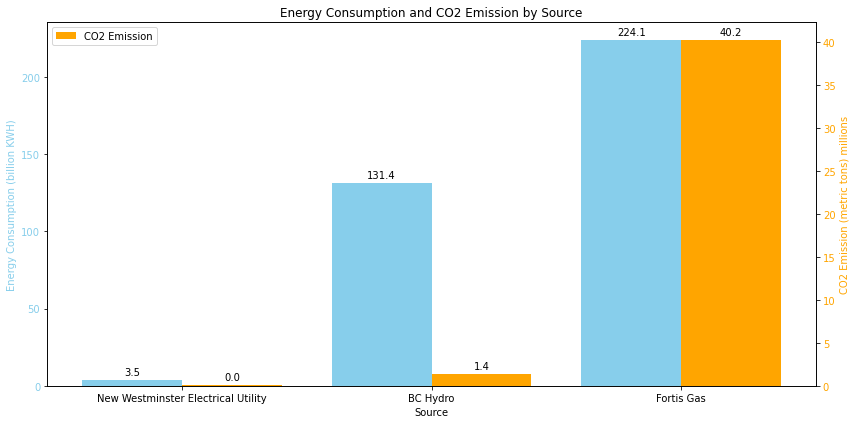

In [19]:
total_energy_pandas = Total_energy_source.toPandas()
fig, ax1 = plt.subplots(figsize=(12, 6))
total_energy_pandas['Energy_Consumption'] = total_energy_pandas['Energy_Consumption'].astype(float)
total_energy_pandas['CO2_Emission'] = total_energy_pandas['CO2_Emission'].astype(float)

energy_in_billions = total_energy_pandas['Energy_Consumption'] / 1e9
bar1 = ax1.bar(total_energy_pandas.index - 0.2, energy_in_billions, color='skyblue', width=0.4, label='Energy Consumption')
ax1.set_xlabel('Source')
ax1.set_ylabel('Energy Consumption (billion KWH)', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')
ax2 = ax1.twinx()

co2_in_metric_tons = total_energy_pandas['CO2_Emission'] / 1e6
bar2 = ax2.bar(total_energy_pandas.index + 0.2, co2_in_metric_tons, color='orange', width=0.4, label='CO2 Emission')
ax2.set_ylabel('CO2 Emission (metric tons) millions', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

for rect in bar1:
    height = rect.get_height()
    ax1.annotate(f'{height:.1f}', xy=(rect.get_x() + rect.get_width() / 2, height), xytext=(0, 3),
            textcoords="offset points", ha='center', va='bottom')

for rect in bar2:
    height = rect.get_height()
    ax2.annotate(f'{height:.1f}', xy=(rect.get_x() + rect.get_width() / 2, height), xytext=(0, 3),
             textcoords="offset points", ha='center', va='bottom')

plt.title('Energy Consumption and CO2 Emission by Source')
plt.xticks(total_energy_pandas.index, total_energy_pandas['Source'])
plt.legend()
plt.tight_layout()  
plt.show()


### Graph 6 - CO2 emission distribution by max Co2 producing Source 

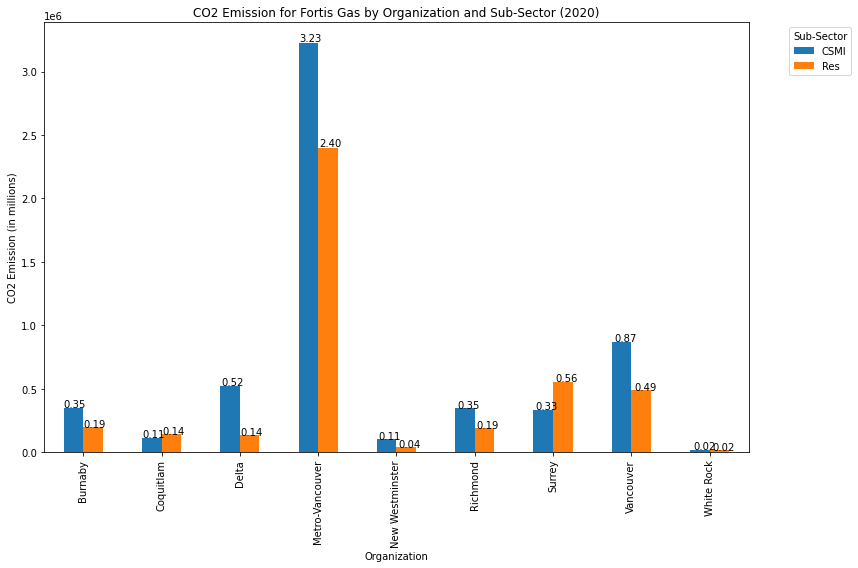

In [20]:
fortis_gas_pd = Fortis_gas_areas.toPandas()
pivot_data = fortis_gas_pd.pivot(index='ORG_NAME', columns='SUB_SECTOR', values='CO2_Emission')
ax = pivot_data.plot(kind='bar', figsize=(12, 8))
for p in ax.patches:
    ax.annotate(f'{p.get_height() / 1_000_000:.2f}', (p.get_x() * 1.005, p.get_height() * 1.005))
plt.xlabel('Organization')
plt.ylabel('CO2 Emission (in millions)')
plt.title('CO2 Emission for Fortis Gas by Organization and Sub-Sector (2020)')
plt.legend(title='Sub-Sector', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Machine Learning

In [21]:
#Model : Linear Regression to see the co2 Emission for next 4 years general trend
selected_features = ['YEAR']
label_column = 'Total_CO2_Emission'

assembler = VectorAssembler(inputCols=selected_features, outputCol='features')
predictions_list = []

specified_org_types = ['City', 'District Municipality', 'Regional District']

for org_type in specified_org_types:
    org_type_data = CO2_emissions.filter(CO2_emissions['ORG_TYPE'] == org_type)
    model_linearregression = LinearRegression(featuresCol='features', labelCol=label_column)
    pipeline = Pipeline(stages=[assembler, model_linearregression])
    model = pipeline.fit(org_type_data)
 
    years_for_prediction = spark.range(2021, 2025).withColumnRenamed("id", "YEAR")
    prediction_data = years_for_prediction
    predictions = model.transform(prediction_data).select('YEAR', 'prediction').withColumn('ORG_TYPE', F.lit(org_type))
    predictions_list.append(predictions)

combined_predictions = predictions_list[0]
for i in range(1, len(predictions_list)):
    combined_predictions = combined_predictions.union(predictions_list[i])
    
combined_predictions.show()

+----+------------------+--------------------+
|YEAR|        prediction|            ORG_TYPE|
+----+------------------+--------------------+
|2021|3864741.4999822676|                City|
|2022|3830712.4999751747|                City|
|2023|3796683.4999680817|                City|
|2024|3762654.4999609888|                City|
|2021| 716199.5000143126|District Municipa...|
|2022| 741668.8000200391|District Municipa...|
|2023| 767138.1000257656|District Municipa...|
|2024| 792607.4000314996|District Municipa...|
|2021| 5778779.999992549|   Regional District|
|2022| 5763184.199989568|   Regional District|
|2023| 5747588.399986587|   Regional District|
|2024|5731992.5999836065|   Regional District|
+----+------------------+--------------------+



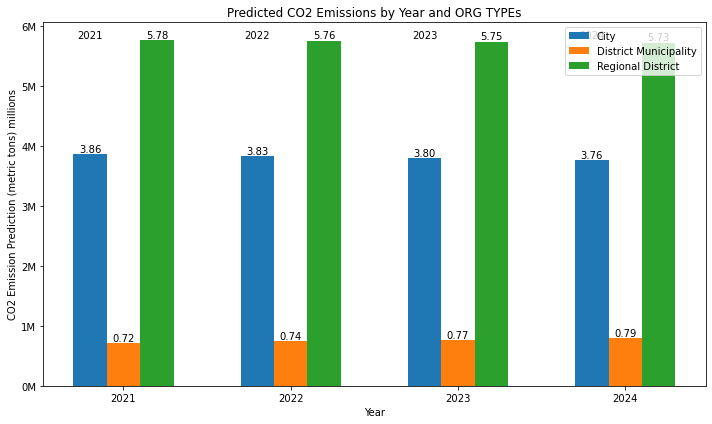

In [22]:
combined_predictions_pd = combined_predictions.toPandas()   

org_types = combined_predictions_pd['ORG_TYPE'].unique()
years = combined_predictions_pd['YEAR'].unique()
bar_width = 0.2
index = list(range(len(years)))
plt.figure(figsize=(10, 6))

for i, org_type in enumerate(org_types):
    data = combined_predictions_pd[combined_predictions_pd['ORG_TYPE'] == org_type] 
    plt.bar([x + i * bar_width for x in index], data['prediction'], bar_width, label=org_type)  
    for j, value in enumerate(data['prediction']):
        plt.text(j + i * bar_width, value + 0.1, f'{value / 1e6:.2f}', ha='center', va='bottom')
for i, year in enumerate(years):
    plt.text(i, max(combined_predictions_pd['prediction']) + 0.3, str(year), ha='center', va='bottom')

plt.xlabel('Year')
plt.ylabel('CO2 Emission Prediction (metric tons) millions')
plt.title('Predicted CO2 Emissions by Year and ORG TYPEs')
plt.xticks([r + bar_width for r in range(len(years))], years)
plt.legend()
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x/1e6)}M'))
plt.tight_layout()
plt.show()